<a href="https://colab.research.google.com/github/arikyusufb/Emissions/blob/main/emissions_final%20assignment_YA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

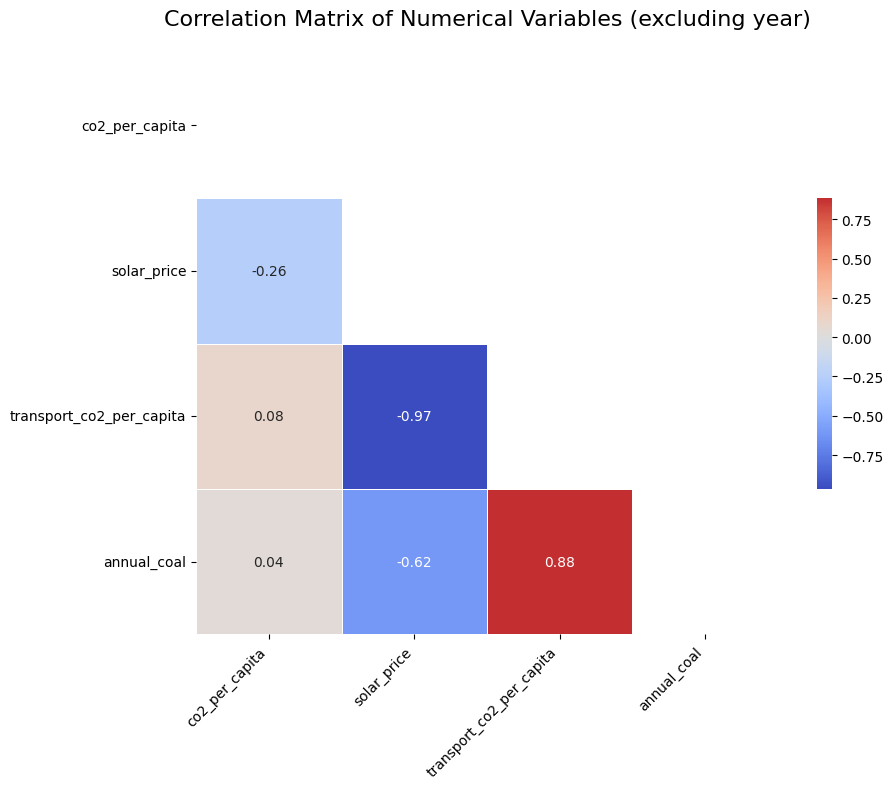

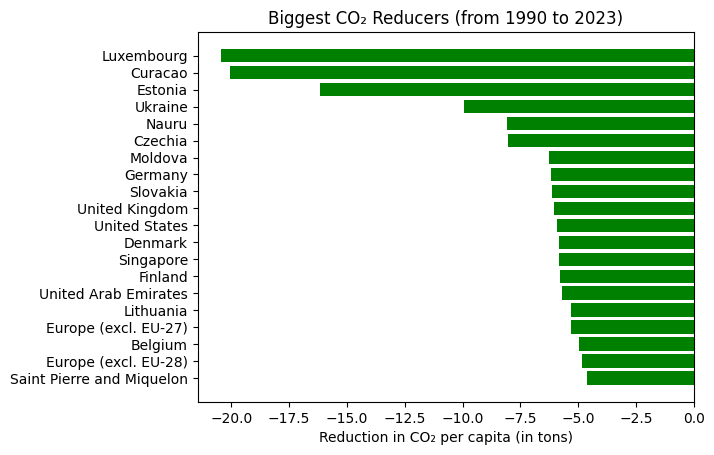

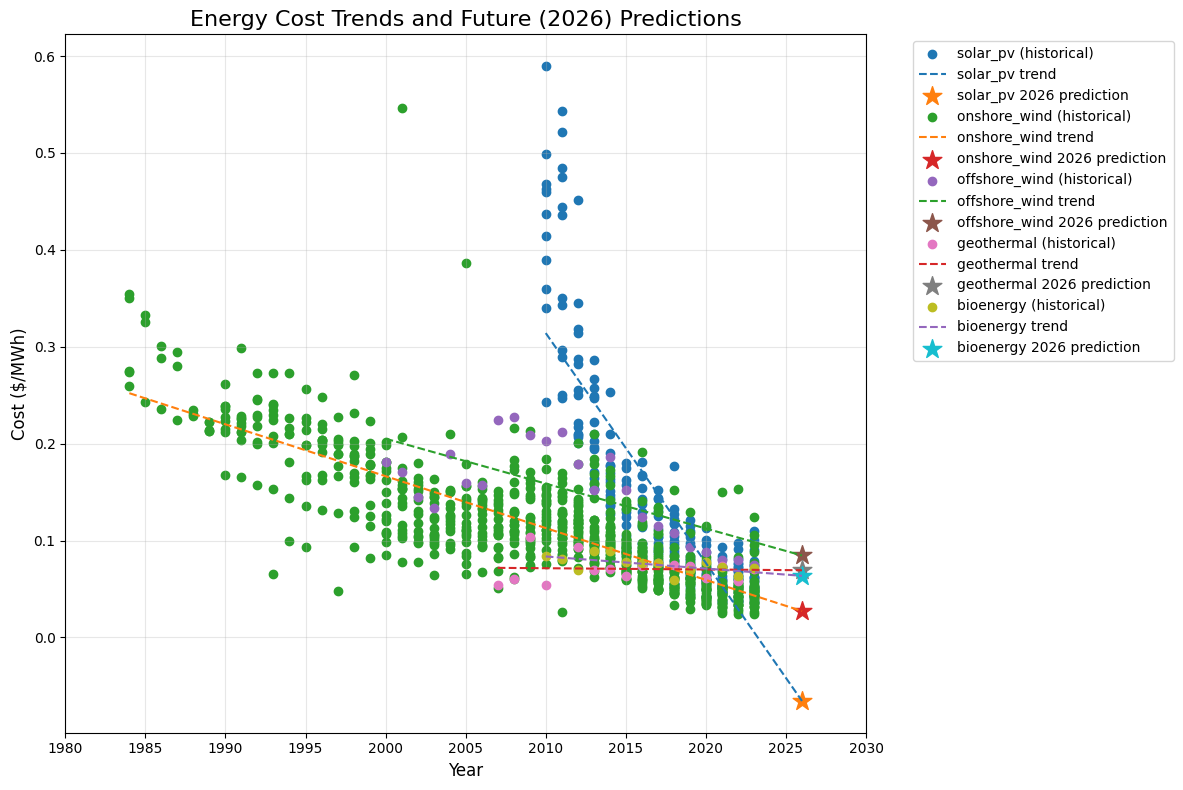

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 1. What is the biggest predictor of a large CO2 output per capita of a country?

# Load datasets
urls = {
    "co2_per_capita": "https://raw.githubusercontent.com/arikyusufb/Emissions/refs/heads/main/co-emissions-per-capita.csv",
    "solar_pv_prices": "https://raw.githubusercontent.com/arikyusufb/Emissions/refs/heads/main/solar-pv-prices.csv",
    "co2_emissions_transport": "https://raw.githubusercontent.com/arikyusufb/Emissions/refs/heads/main/co2-emissions-transport.csv",
    "annual_co2_coal": "https://raw.githubusercontent.com/arikyusufb/Emissions/refs/heads/main/annual-co2-coal.csv"
}

df_datasets = {name: pd.read_csv(url) for name, url in urls.items()}

# Rename columns
df_datasets['co2_per_capita'].rename(columns={
    'Entity': 'country', 'Year': 'year', 'Annual CO₂ emissions (per capita)': 'co2_per_capita'
}, inplace=True)

df_datasets['solar_pv_prices'].rename(columns={
    'Entity': 'country', 'Year': 'year', 'Solar photovoltaic module price': 'solar_price'
}, inplace=True)

df_datasets['co2_emissions_transport'].rename(columns={
    'Entity': 'country', 'Year': 'year', 'Carbon dioxide emissions from transport': 'transport_co2_per_capita'
}, inplace=True)

df_datasets['annual_co2_coal'].rename(columns={
    'Entity': 'country', 'Year': 'year', 'Annual CO₂ emissions from coal': 'annual_coal'
}, inplace=True)

# Merge datasets
main_df = df_datasets['co2_per_capita'][['country', 'year', 'co2_per_capita']].copy()
for name in ['solar_pv_prices', 'co2_emissions_transport', 'annual_co2_coal']:
    main_df = main_df.merge(df_datasets[name], on=['country', 'year'], how='left')

# Drop NaN values
main_df.dropna(subset=['co2_per_capita'], inplace=True)
def plot_correlations(df):
    """
    Plot a correlation matrix heatmap for numerical columns in the dataframe,
    excluding the 'year' column.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data to plot correlations
    """
    # Select only numerical columns for correlation, excluding 'year'
    numerical_df = df.select_dtypes(include=[np.number]).drop(columns=['year'], errors='ignore')

    # Calculate correlation matrix
    corr_matrix = numerical_df.corr()

    # print(corr_matrix)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the mask
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # Add title and adjust layout
    plt.title("Correlation Matrix of Numerical Variables (excluding year)", pad=20, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Call the function with your main dataframe
plot_correlations(main_df)

# Get the CO2 data
co2 = df_datasets['co2_per_capita']

# Find first and last year
first_year = 1990#co2['year'].min()
last_year = 2023#co2['year'].max()

# Calculate changes
changes = []
for country in co2['country'].unique():
    first = co2[(co2['country'] == country) & (co2['year'] == first_year)]['co2_per_capita'].mean()
    last = co2[(co2['country'] == country) & (co2['year'] == last_year)]['co2_per_capita'].mean()
    changes.append((country, last - first))

# Convert to DataFrame
changes_df = pd.DataFrame(changes, columns=['country', 'change'])

# Get top 10 reducers
top_10 = changes_df.sort_values('change').head(20)
top_10 = top_10.iloc[::-1]

# Simple plot
plt.barh(top_10['country'], top_10['change'], color='green')
plt.title("Biggest CO₂ Reducers (from " + str(first_year) + " to " + str(last_year) + ")")
plt.xlabel("Reduction in CO₂ per capita (in tons)")
plt.show()

# 3. Which non-fossil fuel energy technology will have the best price in the future?
# Linear regression over the various non-fossil fuel options.
# Get the energy cost data
# Load datasets
urls = {
    "levelized_cost_en_url": "https://raw.githubusercontent.com/arikyusufb/Emissions/refs/heads/main/levelized-cost-of-energy.csv"
}

df_datasets = {name: pd.read_csv(url) for name, url in urls.items()}

cost_df = df_datasets['levelized_cost_en_url'].copy()


# Rename columns for easier use
cost_df = cost_df.rename(columns={
     'Entity': 'country',
     'Year': 'year',
     'Geothermal levelized cost of energy': 'geothermal',
     'Bioenergy levelized cost of energy': 'bioenergy',
     'Offshore wind levelized cost of energy' : 'offshore_wind',
     'Solar photovoltaic levelized cost of energy' : 'solar_pv',
     'Concentrated solar power levelized cost of energy' : 'concentrated_solar',
     'Hydropower levelized cost of energy' : 'hydropower',
     'Onshore wind levelized cost of energy' : 'onshore_wind'
     })


# Focus on non-fossil technologies we care about
clean_techs = ['solar_pv', 'onshore_wind', 'offshore_wind', 'geothermal','bioenergy']
clean_df = cost_df.dropna(subset=clean_techs).copy()  # Only keeps rows with ALL techs present

# First, calculate all predictions (this is the for loop part)
# Create figure
plt.figure(figsize=(12, 8))

# Calculate and plot for each technology
future_year = 2026
future_cost = {}
for tech in clean_techs:
    tech_data = cost_df[['year', tech]].dropna()

    if len(tech_data) > 2:  # Need at least 3 data points
        # Historical data
        plt.scatter(tech_data['year'], tech_data[tech], label=f'{tech} (historical)')

        # Linear regression
        x = tech_data['year'].values.reshape(-1, 1)
        y = tech_data[tech].values
        model = LinearRegression()
        model.fit(x, y)

        # Prediction for future year
        future_cost = model.predict([[future_year]])[0]

        # Plot regression line
        years_to_plot = np.array([tech_data['year'].min(), future_year]).reshape(-1, 1)
        predicted = model.predict(years_to_plot)
        plt.plot(years_to_plot, predicted, '--', label=f'{tech} trend')

        # Mark future prediction point
        plt.scatter(future_year, future_cost, marker='*', s=200, label=f'{tech} {future_year} prediction')

# Format plot
plt.title('Energy Cost Trends and Future (' + str(future_year) + ') Predictions', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cost ($/MWh)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(1980, 2035, 5))
plt.tight_layout()

plt.show()


